In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import cv2 
import numpy as np
import random

from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/My Drive/ecse415/Assignments/a3/'


Mounted at /content/drive


# 1. Data

In [ ]:
image_path = []
for directory_name, _, file_names in os.walk(path+"Color_FERET_Database"):
    for filename in file_names:
        img_path.append(os.path.join(directory_name, filename))

In [ ]:
images = []
subjects = []

width = 512 // 4
height = 768 // 4 
dim = (width, height)

for image in image_path:
  img_gray = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
  images.append(cv2.resize(img_gray, dim, interpolation = cv2.INTER_AREA))
  subjects.append(os.path.basename(image)[0:5])  

# images is an array with all the 1916 images
images = np.asarray(images)
# subjects is an array with all the 1916 corresponding subject numbers (you could think of them as labels)
subjects = np.asarray(subjects)


In [ ]:
print("1. Subjects shape: ", subjects.shape)
print("2. Images shape: ", images.shape)

1. Subjects shape:  (1916,)
2. Images shape:  (1916, 192, 128)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local


images_train.shape:  (41,)
images_test.shape:  (11,)
subjects_train.shape:  (41,)
subjects_test.shape:  (11,)



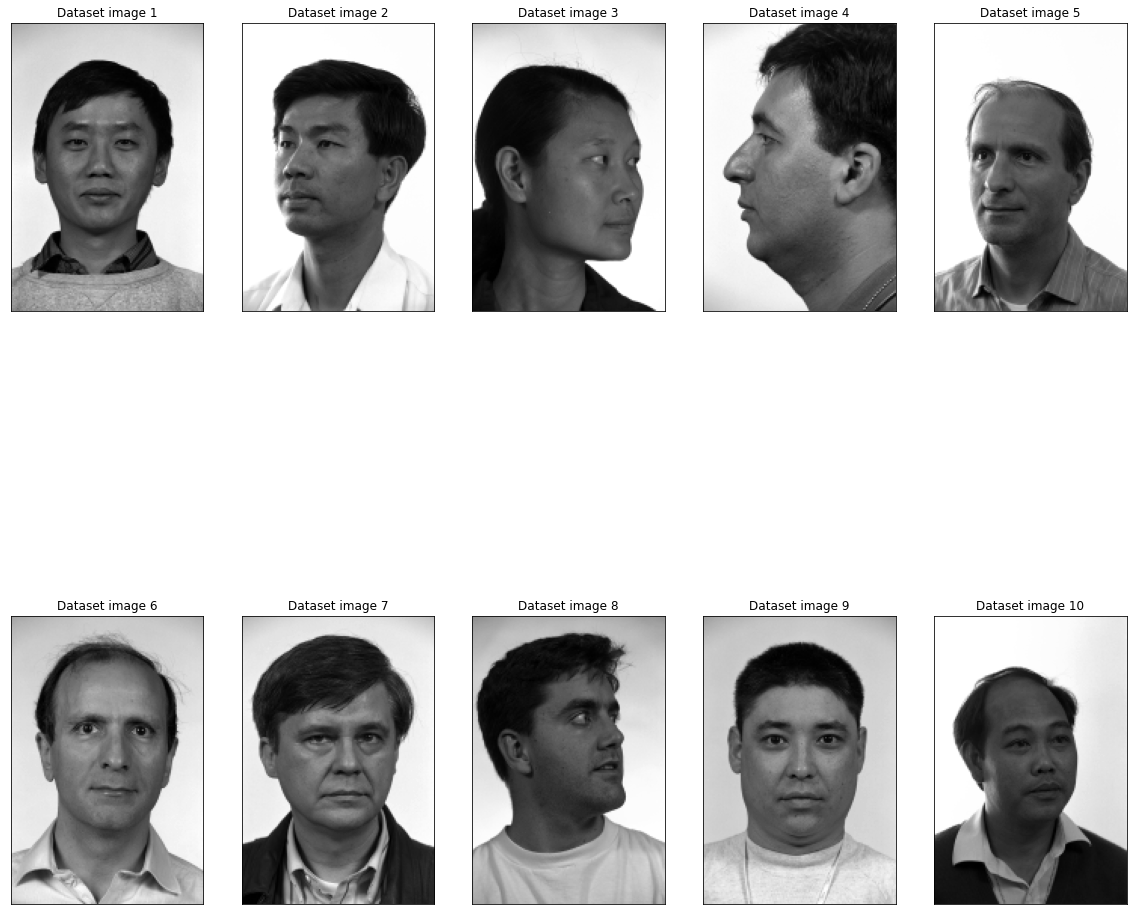

In [ ]:
images_train = []
images_test = []
images_pretrain_temp = []

subjects_train = []
subjects_test = []
subjects_pretrain_temp = []

for subject in np.unique(subjects):
  # images_temp is an array with all the images of a specific subject.
  images_temp = images[np.min(np.where(subject==subjects)) : np.max(np.where(subject==subjects)) + 1]
  # subjects_temp is a list with the subject number * the number of images of that subject.
  subjects_temp = [subject]*images_temp.shape[0]

  images_pretrain_temp.append(images_temp)
  subjects_pretrain_temp.append(subjects_temp)

# split the data into train and test data.
images_train, images_test, subjects_train, subjects_test = train_test_split(images_pretrain_temp, subjects_pretrain_temp,train_size=0.8, test_size = 0.2)

images_train = np.array(images_train)
images_test = np.array(images_test)
subjects_train = np.array(subjects_train)
subjects_test = np.array(subjects_test)

print()
print("images_train.shape: ", images_train.shape) # images_train.shape:  (41,)
print("images_test.shape: ", images_test.shape) # images_test.shape:  (11,)
print("subjects_train.shape: ", subjects_train.shape) # subjects_train.shape:  (41,)
print("subjects_test.shape: ", subjects_test.shape) # subjects_test.shape:  (11,)
print()

plt.figure(figsize=(20, 20))
for i in range(1, 11):
  plt.subplot(2,5,i)
  randint = random.randint(0, 1915)
  plt.imshow(images[randint], cmap="gray")
  plt.xticks([]), plt.yticks([])
  plt.title("Dataset image " + str(i))
plt.show()


# 2. Eigenface Representation 

In [ ]:
data_mat = np.ndarray(shape=(height*width,1515)) #  80% of images
x = 0
for i in range(0, 41):
  for j in range(0,images_train[i].shape[0]):
    image = images_train[i][j]
    data_mat[:,x] = np.array(image).flatten()
    x = x + 1

# http://www.vision.jhu.edu/teaching/vision08/Handouts/case_study_pca1.pdf
mean_face = np.mean(data_mat, axis=1).reshape(data_mat.shape[0], 1)
data_mat_subt_mean_face = np.subtract(data_mat, mean_face)
transpose_dot = np.nan_to_num(np.dot(np.transpose(data_mat_subt_mean_face), data_mat_subt_mean_face), copy=False)
eigenvalues, eigenvectors = np.linalg.eig(transpose_dot)
eigenvectors_dot = np.dot(data_mat_subt_mean_face, eigenvectors)
sorted_eigenvalues_ind = eigenvalues.argsort()[::-1] 
eigenvalues_sorted = eigenvalues[sorted_eigenvalues_ind]
eigenvectors_sorted_eigenvalues = eigenvectors_dot[:,sorted_eigenvalues_ind]

Text(0, 0.5, 'Normalized variance')

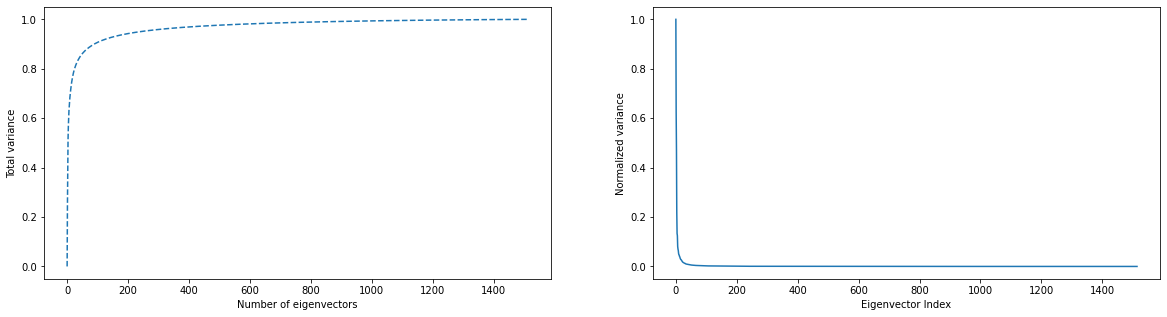

In [ ]:
explained_variance = []

for i in range(len(eigenvalues_sorted)):
    explained_variance.append(np.sum(eigenvalues_sorted[:i])/np.sum(eigenvalues_sorted))

plt.figure(figsize=(20, 5))
plt.subplot(121), plt.plot(explained_variance,'--')
plt.xlabel('Number of eigenvectors')
plt.ylabel('Total variance')

plt.subplot(122), plt.plot(eigenvalues_sorted/eigenvalues_sorted.max())
plt.xlabel('Eigenvector Index')
plt.ylabel('Normalized variance')

**Do you need all the vectors to represent the data?**

*   No, we do not need all the vectors to represent our data. Most of the variance is represented by the first few vectors. PCA allows us to "compress" the data into a much smaller size by only taking a fraction of the vectors. The change in variance is minimal after the first few vectors



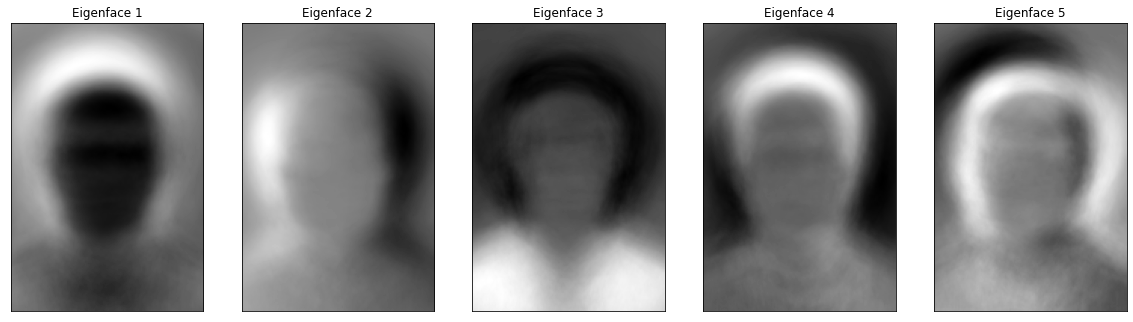

In [ ]:
plt.figure(figsize=(20, 20))
for i in range(1, 6):
  plt.subplot(1,5,i)
  plt.imshow(eigenvectors_sorted_eigenvalues[:,(i-1)].reshape(height,width).astype(np.float64), cmap="gray")
  plt.xticks([]), plt.yticks([])
  plt.title("Eigenface " + str(i))
plt.show()

# 3. Classification

In [ ]:
images_train_full = images_train[0]
for i in range(1,len(images_train)):
  images_train_full = np.append(images_train_full, images_train[i], axis = 0)
print(images_train_full.shape)

images_test_full = images_test[0]
for i in range(1,len(images_test)):
  images_test_full = np.append(images_test_full, images_test[i], axis = 0)
print(images_test_full.shape)

subjects_train_full = subjects_train[0]
for i in range(1,len(subjects_train)):
  subjects_train_full = np.append(subjects_train_full, subjects_train[i], axis = 0)
print(subjects_train_full.shape)

subjects_test_full = subjects_test[0]
for i in range(1,len(subjects_test)):
  subjects_test_full = np.append(subjects_test_full, subjects_test[i], axis = 0)
print(subjects_test_full.shape)

images_pretrain_temp_full = images_pretrain_temp[0]
for i in range(1,len(images_pretrain_temp)):
  images_pretrain_temp_full = np.append(images_pretrain_temp_full, images_pretrain_temp[i], axis = 0)
print(images_pretrain_temp_full.shape)

subjects_pretrain_temp_full = subjects_pretrain_temp[0]
for i in range(1,len(subjects_pretrain_temp)):
  subjects_pretrain_temp_full = np.append(subjects_pretrain_temp_full, subjects_pretrain_temp[i], axis = 0)
print(subjects_pretrain_temp_full.shape)

(1515, 192, 128)
(401, 192, 128)
(1515,)
(401,)
(1916, 192, 128)
(1916,)


## 3.1. original high dimensional pixel space

In [ ]:
from sklearn.neighbors import KNeighborsClassifier as knc

# K Neighbors Classifier
knn = knc(n_neighbors = 1)

# fit model
knn.fit(images_train_full.reshape((1515,24576)), subjects_train_full)

predicted = knn.predict(np.asarray(images_pretrain_temp_full).reshape((1916,24576)))

# Find accuracy of results
accurate = 0
for i in range(len(predicted)):
  if predicted[i] == subjects_pretrain_temp_full[i]:
    accurate += 1
print("accuracy is", accurate, "out of 1916")


accuracy is 1515 out of 1916


## 3.2. Eigenspace

Incomplete. Couldnt make time to do it.

## 3.3. SVM

Incomplete. Couldnt make time to do it.

# 4. Face Detection

threshold:  46000000000000
step size:  30
Number of faces detected:  6


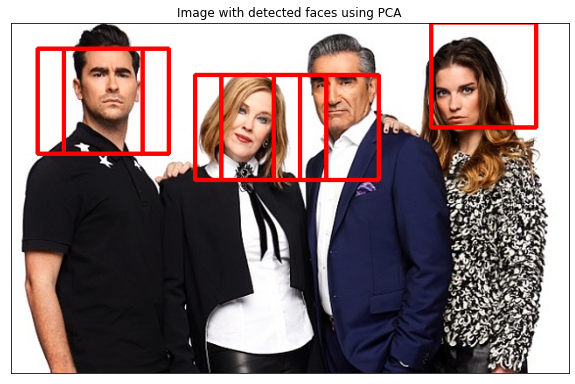

In [ ]:
img = cv2.imread(path+'Schitts_Creek_group.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY);
img_copy = img.copy()

def eigenface_project(section, num_vect):
  vectors = eigenvectors_sorted_eigenvalues[0:width*height, 0:num_vect]
  section = np.subtract(section,np.mean(data_mat, axis=1))
  vectors_dot_transpose = np.dot(np.transpose(vectors), section)
  array = np.zeros(shape=(width*height,5), dtype=np.float64)
  for i in range(num_vect):
    array[:,i] = vectors_dot_transpose[i] * vectors[:,i]
  return np.linalg.norm(np.subtract(section, array.sum(axis=1)), axis=0)
# ------------------------------------------------------------------------------
def detect_faces(original, thresh, step_size, window_size, num_vect):
  num_faces = 0
  window_width,window_height = window_size
  img_numrows,img_numcols = img_gray.shape
  for i in range(0, img_numrows-window_height,step_size):
      for j in range(0, img_numcols-window_width, step_size):
          section = cv2.resize(img_gray[i:i+window_height,j:j+window_width], (height,width)).flatten()
          euclidean_dist = eigenface_project(section, num_vect)
          if euclidean_dist < thresh:
            num_faces = num_faces + 1
            cv2.rectangle(img_copy, (j, i), (j+window_width, i+window_height), (255, 0, 0), 3)
  return num_faces

threshold = 46000000000000
step_size = 30
num_faces = detect_faces(img,threshold, step_size, (120,120), 5)
print("threshold: ", threshold)
print("step size: ", step_size)
print("Number of faces detected: ", num_faces)

# display image with detected faces
plt.figure(figsize=(10, 10))  # width, height
plt.subplot(111), plt.imshow(img_copy, cmap="gray")
plt.title("Image with detected faces using PCA"), plt.xticks([]), plt.yticks([])
plt.show()



# Viola Jones

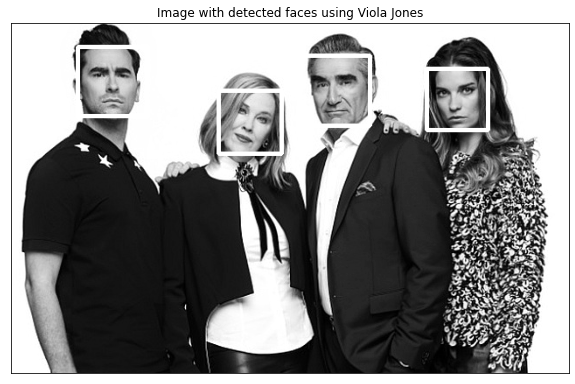

In [ ]:
data_path = cv2.data.haarcascades
face_cascade = cv2.CascadeClassifier( os.path.join(data_path, 'haarcascade_frontalface_default.xml'))
img_gray = cv2.imread(path+'Schitts_Creek_group.jpg', cv2.IMREAD_GRAYSCALE)
faces = face_cascade.detectMultiScale(img_gray, 1.1, 3)

for (x,y,w,h) in faces:
    img_gray = cv2.rectangle(img_gray,(x,y),(x+w,y+h),(255,0,0),3)

# display image with detected faces
plt.figure(figsize=(10, 10))  # width, height
plt.subplot(111), plt.imshow(img_gray, cmap="gray")
plt.title("Image with detected faces using Viola Jones"), plt.xticks([]), plt.yticks([])
plt.show()

## Comparison of implemented PCA and Viola Jones

### PCA


*   true positives: 6
*   false positives: 0
*   false negatives: 0






### Viola Jones


*   true positives: 4
*   false positives: 0
*   false negatives: 0



**Under what conditions would you expect the Viola-Jones detector to work when 
PCA does not?**

*   PCA normally focuses on the 'mean' or 'shared' features of a set of images, it also ignores the variabilities in these images. Therefore, it might not be suitable for real-time detection of moving objects like autonomous cars.
*   Viola-Jones doesn't only focus on the 'shared' features of the object that we want to detect, therefore it would work for a real-time moving object.

